# **Final Project (section 5 - tumors)**

In [52]:
import os
import sys
import cv2 as cv
import numpy as np
import csv
#import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, mean_squared_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from math import sqrt

import importlib
from utils import Orb
from utils import siftKP

## 5.1 Preparing Data

Load Source Dataset (done locally)

In [31]:
np.set_printoptions(threshold=sys.maxsize)

In [32]:
path = os.path.join('.', 'QC')
rgb_dir = os.path.join(path, "rgb")
mask_dir = os.path.join(path, "mask")
csv_dir = os.path.join(path, "csv")
split_path = os.path.join(path, 'split')

image_files = os.listdir(rgb_dir)
mask_files = os.listdir(mask_dir)
csv_files = os.listdir(csv_dir)

image_files.sort()
mask_files.sort()
csv_files.sort()

5.1.1  Convert Image and Masks to Grayscale

In [33]:
def loadGray(id):
    image_path = os.path.join(rgb_dir, id)
    image = cv.imread(image_path + '.png')
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    #plt.imshow(mask, cmap = 'gray')

    mask_path = os.path.join(mask_dir, id)
    mask = cv.imread(mask_path + '.png')
    mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
    #plt.imshow(mask, cmap = 'gray')


    return image, mask


5.1.2.  Multiply the Mask and the original to obtain regions of interest

In [34]:
def ROI(image, mask):
    # Ensure the mask and image are the same size
    min_height = min(image.shape[0], mask.shape[0])
    min_width = min(image.shape[1], mask.shape[1])

    image = image[:min_height, :min_width]
    mask = mask[:min_height, :min_width]

    # Threshold mask to find the actual ROI
    _, mask_binary = cv.threshold(mask, 1, 255, cv.THRESH_BINARY)  # Ensure binary mask (0 or 255)

    # Find contours of the mask to get the actual ROI bounding box
    contours, _ = cv.findContours(mask_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return np.zeros_like(image)  # Return an empty image if no mask is found

    # Get bounding box around the mask
    x, y, w, h = cv.boundingRect(contours[0])

    # Crop to the actual mask region
    mask_cropped = mask_binary[y:y+h, x:x+w]

    # Normalize and apply mask
    mask_cropped = mask_cropped.astype(np.float32) / 255.0  # Normalize mask

    # multiply cropped region of new mask with cropped mask
    newMask = 1-mask
    newMask[y:y+h, x:x+w] = newMask[y:y+h, x:x+w] * mask_cropped


    roi = newMask * image

    return roi


5.1.3. Remove background noice

In [35]:
def backgroundRemove(roi, mask):
    # Ensure the mask and roi are the same size
    min_height = min(roi.shape[0], mask.shape[0])
    min_width = min(roi.shape[1], mask.shape[1])

    roi = roi[:min_height, :min_width]
    mask = mask[:min_height, :min_width]

    _, binary_mask = cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    result = np.where((roi != 0), roi * (1-binary_mask/255), 0)


    return result


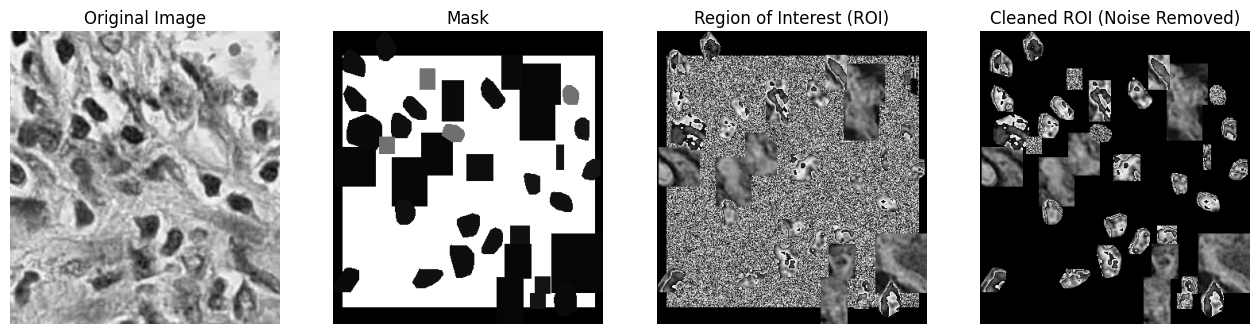

In [36]:
subject_id = "TCGA-A2-A0T0-DX1_id-5ea40989ddda5f839897f293_left-76950_top-61480_bottom-61778_right-77225"
image, mask = loadGray(subject_id)
roi = ROI(image,mask)
final = backgroundRemove(roi, mask)

# Display results
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(mask, cmap="gray")
axs[1].set_title("Mask")
axs[1].axis("off")

axs[2].imshow(roi, cmap='gray')
axs[2].set_title("Region of Interest (ROI)")
axs[2].axis("off")

axs[3].imshow(final, cmap='gray')
axs[3].set_title("Cleaned ROI (Noise Removed)")
axs[3].axis("off")

plt.show()

Extract features

In [37]:
# get train, val patients
train_csv = os.path.join(split_path, 'train_subjects.csv')
val_csv = os.path.join(split_path, 'validate_subjects.csv')

def getPatients(csvPath):
    with open(csvPath, newline='') as csvfile:
        reader = csv.reader(csvfile)
        ids = list(reader)
    ids = ids[1:] # strip PatientID
    ids.sort()
    return ids

train_ids = getPatients(train_csv)
val_ids = getPatients(val_csv)

# get train, val image IDs
def getImages(ids):
    data = []
    for patient in ids:
        for filename in image_files:
            done = False
            if (filename.startswith(patient[0])):
                name = filename[:-4] # strip .png
                data.append(name)
                done = True
            elif (done):
                break # files are sorted
    return data

train_data = getImages(train_ids)
val_data = getImages(val_ids)

### Orb

In [38]:
## EXTRACT AND CLASSIFY FEATURES ##
# get ROIs and labels for tumor/non tumor from csv
def labelsAndPixels(imageName):
    csvName = imageName + '.csv'
    labels = [] # blob label
    coords = [] # blob coordinates in form: ((xmin, xmax), (ymin, ymax))

    csvPath = os.path.join(csv_dir, csvName)
    with open(csvPath, newline='') as f:
        reader = csv.reader(f)
        next(reader) # skip first row
        for row in reader:
            labels.append(row[1])
            # get min and max x and y coords for ROI
            xcoords = (float(row[5]), float(row[7]))
            ycoords = (float(row[6]), float(row[8]))
            coords.append((xcoords, ycoords))
            c = (xcoords, ycoords)

    return labels, coords #TODO: TEST

def preprocess(imageName):
    # preprocess image to remove background
    image, mask = loadGray(imageName)
    roi = ROI(image, mask)
    img = backgroundRemove(roi, mask)

    # normalize and convert to uint8 for cv2
    img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)
    img = img.astype(np.uint8)
    # get mask to avoid getting keypoints at black bounds of ROI
    mask = (img != 0).astype(np.uint8) * 255
    return img, mask

# extract features from image and classify
def featuresClassify(imageName, doSIFT=True, visualize=False, doMask=True):
    """"    Extracts ORB features from only the foreground image and get ground
            truth based on the blob labels in the .csv
            Takes as argument image id (no .png)
            Returns:
                imgLabels: list of all labels for descriptors
                imgFeatures: list of all feature descriptors """
    image, mask = loadGray(imageName)
    orb = cv.ORB_create(nfeatures=50)

    if doMask:
        # preprocess image to remove background
        roi = ROI(image,mask)
        img = backgroundRemove(roi, mask)

        # normalize and convert to uint8 for cv2
        img = cv.normalize(img, None, 0, 255, cv.NORM_MINMAX)
        img = img.astype(np.uint8)
        # get mask to avoid getting keypoints at black bounds of ROI
        mask = (img != 0).astype(np.uint8) * 255

        # extract Orb features
        orbkp, features = orb.detectAndCompute(img, mask)
    else:
        img = image
        orbkp, features = orb.detectAndCompute(img, None)

    # extract SIFT features at Orb keypoints if doSIFT=True
    if(doSIFT):
        _, siftdes = siftKP(img, orbkp)
        # concatenate orb + sift
        features = np.hstack((features, siftdes))

    # plot keypoints
    if (visualize):
        img2 = cv.drawKeypoints(img, orbkp, None)
        plt.figure()
        plt.imshow(img2)

    # get labelled regions to classify features
    labels, coords = labelsAndPixels(imageName)

    # label orb descriptors from .csv file
    imgLabels = []
    imgFeatures = []
    for i, kp in enumerate(orbkp):
        x, y = kp.pt
        for j, bounds in enumerate(coords):
            (xmin, xmax), (ymin, ymax) = bounds #TODO: bounds

            # find the region the keypoint falls in
            found = False
            if xmin <= x <= xmax and ymin <= y <= ymax:
                label = labels[j]
                found = True
                break
        if (found == False):
            label = 'unlabeled' # not identified in CSV
        imgLabels.append(label)
        imgFeatures.append(features[i])

    return imgLabels, imgFeatures, orbkp

Classify features, get train and test x and y sets

In [39]:
# extract and classify features for all images in dataset
def classifyData(data, doMask=True):
    print(f'Classifying data: {len(data)} Images.')
    setLabels = []
    setFeatures = []
    for name in tqdm(data):
        l, f, kp = featuresClassify(name, doMask=doMask)
        setLabels.extend(l)
        setFeatures.extend(f)
    print(f"{setLabels.count('tumor')} tumor features out of {len(setLabels)} features in the dataset")
    return setFeatures, setLabels, kp


In [40]:
## FROM MASKED IMAGE
# classify train data
trainFeatures, trainLabels, trainkp = classifyData(train_data, doMask=True)
xTrain = trainFeatures
yTrain = ['non_tumor' if label != 'tumor' else label for label in trainLabels]

# classify val data
valFeatures, valLabels, valkp = classifyData(val_data, doMask=True)
xVal = valFeatures
yVal = ['non_tumor' if label != 'tumor' else label for label in valLabels]

Classifying data: 1357 Images.


100%|██████████| 1357/1357 [00:50<00:00, 26.64it/s]


25739 tumor features out of 66124 features in the dataset
Classifying data: 387 Images.


100%|██████████| 387/387 [00:16<00:00, 23.28it/s]

7638 tumor features out of 18653 features in the dataset


5.2 Train the SVM with ROI

In [41]:
def downsample(x, y, rate=0.20):
    x = np.array(x)
    y = np.array([1 if label == "tumor" else 0 for label in y])  # binarize

    assert x.shape[0] == y.shape[0], "Mismatch in number of samples"

    total_target = int(len(y) * rate)
    tumor_x = x[y == 1]
    nontumor_x = x[y == 0]

    if len(tumor_x) == 0 or len(nontumor_x) == 0:
        raise ValueError("One of the classes is empty")

    max_balanced = 2 * min(len(tumor_x), len(nontumor_x))
    total_target = min(total_target, max_balanced)
    samples_per_class = total_target // 2

    tumor_down = resample(tumor_x, replace=False, n_samples=samples_per_class, random_state=42)
    nontumor_down = resample(nontumor_x, replace=False, n_samples=samples_per_class, random_state=42)

    x_down = np.vstack([tumor_down, nontumor_down])
    y_down = np.array([1]*samples_per_class + [0]*samples_per_class)

    return x_down, y_down

def calcMetrics(clf, xTrain, yTrain, xVal, yVal, label):
    # predict on val data
    y_pred = clf.predict(xVal)
    y_proba = clf.predict_proba(xVal)[:, 1]

    # predict on train data
    yTrain_pred = clf.predict(xTrain)
    yTrain_proba = clf.predict_proba(xTrain)[:, 1]

    yVal_bin = np.array([1 if label == "tumor" else 0 for label in yVal])
    yTrain_bin = np.array([1 if label == "tumor" else 0 for label in yTrain])

    accVal = accuracy_score(yVal_bin, y_pred)
    accTrain = accuracy_score(yTrain_bin, yTrain_pred)
    print("Train accuracy:", accTrain)
    print("Val Accuracy:", accVal)

    roc_aucVal = roc_auc_score(yVal_bin, y_proba)
    roc_aucTrain = roc_auc_score(yTrain_bin, yTrain_proba)
    print("ROC AUC Train:", roc_aucTrain)
    print("ROC AUC Val:", roc_aucVal)

    fprV, tprV, _ = roc_curve(yVal_bin, y_proba)
    fprT, tprT, _ = roc_curve(yTrain_bin, yTrain_proba)
    plt.figure()
    plt.plot(fprV, tprV, label=f"Val AUC = {roc_aucVal:.2f}")
    plt.plot(fprT, tprT, label=f"Train AUC = {roc_aucTrain:.2f}")
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'ROC Curve: {label}')
    plt.legend()
    plt.grid()
    plt.show()
    return y_pred, yTrain_pred

# train the SVM
xTrain_bal, yTrain_bal = downsample(xTrain, yTrain)

clf = SVC(kernel='rbf', probability=True, random_state=42)
clf.fit(xTrain_bal, yTrain_bal)

SVC(probability=True, random_state=42)

Train accuracy: 0.631767588167685
Val Accuracy: 0.5899319144373559
ROC AUC Train: 0.6865998403041189
ROC AUC Val: 0.62520202936865


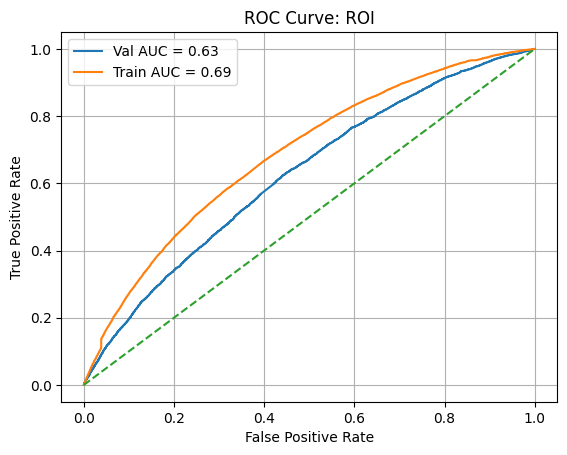


 Training report: 
              precision    recall  f1-score   support

           0       0.73      0.63      0.68     40385
           1       0.52      0.64      0.57     25739

    accuracy                           0.63     66124
   macro avg       0.63      0.63      0.62     66124
weighted avg       0.65      0.63      0.64     66124


 Validation report: 
              precision    recall  f1-score   support

           0       0.67      0.60      0.63     11015
           1       0.50      0.58      0.54      7638

    accuracy                           0.59     18653
   macro avg       0.59      0.59      0.58     18653
weighted avg       0.60      0.59      0.59     18653



In [42]:
# get performance metrics
y_pred, yTrain_pred = calcMetrics(clf, xTrain, yTrain, xVal, yVal, 'ROI')
yPredSave = y_pred

yTrain = ([1 if label == "tumor" else 0 for label in yTrain])
yVal = ([1 if label == "tumor" else 0 for label in yVal])

# convert to 1s and 0s
print("\n Training report: ")
print(classification_report(yTrain, yTrain_pred))
print("\n Validation report: ")
print(classification_report(yVal, y_pred))

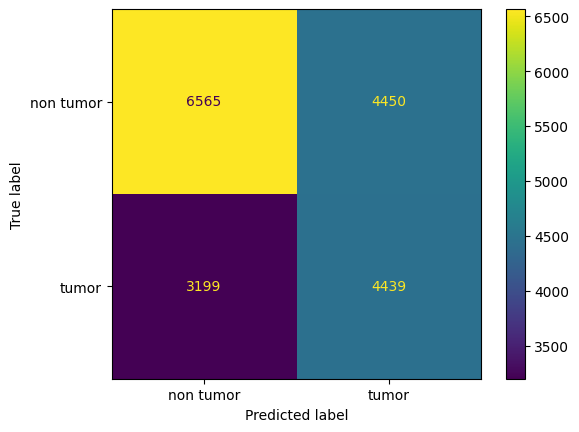

In [58]:
confusionMatrix = confusion_matrix(yVal, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=np.array(['non tumor', 'tumor']))
disp.plot()
plt.show()

In [ ]:
def count_true_tumors(image_name):
    csv_path = os.path.join(csv_dir, image_name + ".csv")
    count = 0
    with open(csv_path, newline='') as f:
        reader = csv.reader(f)
        next(reader)  # skip header
        for row in reader:
            if row[1] == "tumor":
                count += 1
    return count

def countPredTumorROI(imageName, clf):
    _, features, kp = featuresClassify(imageName)
    _, coords = labelsAndPixels(imageName)
    features = np.array(features)
    preds = clf.predict(features)

    count = 0
    # iterate through blobs
    for bounds in coords:
        (xmin, xmax), (ymin, ymax) = bounds
        lbls = []      

        for j, point in enumerate(kp):
            x, y = point.pt      
            # if point in blob, add features
            if xmin <= x <= xmax and ymin <= y <= ymax:
                lbls.append(preds[j])
        
        # find prob that blob is a tumor
        lbls = np.array(lbls)
        if lbls.size != 0:
            probTumor = np.sum(lbls == 1) / lbls.size
            #print(f'Prob tumor: {probTumor}')
            if probTumor > 0.2:
                count += 1
    return count

In [44]:
def calcRMSE(clf):
    # Loop over validation images
    true_counts = []
    pred_counts = []

    for img_id in tqdm(val_data):
        true_n = count_true_tumors(img_id)
        pred_n = countPredTumorROI(img_id, clf)

        true_counts.append(true_n)
        pred_counts.append(pred_n)

    # Compute RMSE
    rmse = sqrt(mean_squared_error(true_counts, pred_counts))
    print("Tumor Count RMSE on Validation Set:", rmse)
    return rmse, true_counts, pred_counts

In [ ]:
rmse1, trueCount1, predCount1 = calcRMSE(clf)

100%|██████████| 387/387 [01:40<00:00,  3.86it/s]

Tumor Count RMSE on Validation Set: 12.241645360691956


In [ ]:
# print(f'avg num tumors: {sum(trueCount1)/len(trueCount1)}')
# print(sum(trueCount1))
# print(sum(predCount1))
# print(trueCount1)
# print(predCount1)

avg num tumors: 12.178294573643411
4713
3166
[32, 2, 24, 36, 30, 23, 0, 0, 0, 2, 6, 0, 0, 1, 7, 14, 14, 28, 15, 23, 30, 25, 21, 0, 0, 11, 19, 26, 8, 0, 0, 34, 0, 0, 22, 26, 28, 25, 10, 0, 0, 14, 12, 7, 16, 16, 17, 12, 20, 12, 23, 0, 11, 2, 0, 17, 19, 3, 9, 16, 0, 5, 9, 0, 16, 2, 15, 0, 18, 0, 0, 12, 12, 11, 17, 24, 0, 19, 22, 0, 14, 22, 1, 19, 21, 6, 16, 16, 19, 9, 11, 16, 3, 22, 24, 19, 6, 0, 19, 16, 30, 19, 15, 0, 24, 0, 25, 4, 4, 0, 32, 0, 10, 19, 0, 0, 11, 16, 2, 0, 0, 1, 0, 49, 0, 0, 10, 11, 25, 13, 29, 2, 27, 0, 0, 0, 8, 2, 0, 13, 4, 42, 8, 26, 24, 30, 13, 25, 27, 24, 54, 42, 0, 24, 15, 38, 23, 26, 0, 0, 33, 2, 27, 34, 30, 39, 35, 11, 26, 33, 45, 37, 39, 37, 37, 3, 0, 1, 1, 0, 1, 1, 0, 0, 0, 15, 0, 9, 2, 0, 0, 0, 0, 0, 0, 1, 1, 20, 7, 28, 21, 16, 18, 20, 30, 0, 1, 1, 0, 0, 0, 24, 27, 19, 19, 22, 16, 28, 18, 10, 24, 17, 21, 33, 0, 0, 21, 11, 0, 25, 42, 0, 18, 14, 21, 15, 15, 13, 10, 6, 12, 21, 17, 8, 18, 0, 32, 7, 14, 20, 28, 43, 12, 0, 9, 20, 19, 0, 13, 18, 21, 3, 0, 22, 20, 24, 

Train on original image

In [46]:
## FROM ORIGINAL IMAGE
# train
oriFeaturesTrain, oriLabelsTrain, orikpTrain = classifyData(train_data, doMask=False)
orixTrain = oriFeaturesTrain
oriyTrain = ['non_tumor' if label != 'tumor' else label for label in oriLabelsTrain]

# val
oriFeaturesVal, oriLabelsVal, orikpVal = classifyData(val_data, doMask=False)
orixVal = oriFeaturesVal
oriyVal = ['non_tumor' if label != 'tumor' else label for label in oriLabelsVal]

Classifying data: 1357 Images.


100%|██████████| 1357/1357 [00:45<00:00, 29.79it/s]


15761 tumor features out of 67738 features in the dataset
Classifying data: 387 Images.


100%|██████████| 387/387 [00:12<00:00, 31.32it/s]

4336 tumor features out of 19347 features in the dataset


Train accuracy: 0.662995659747852
Val Accuracy: 0.640822866594304
ROC AUC Train: 0.7262199488392894
ROC AUC Val: 0.6577867497414566


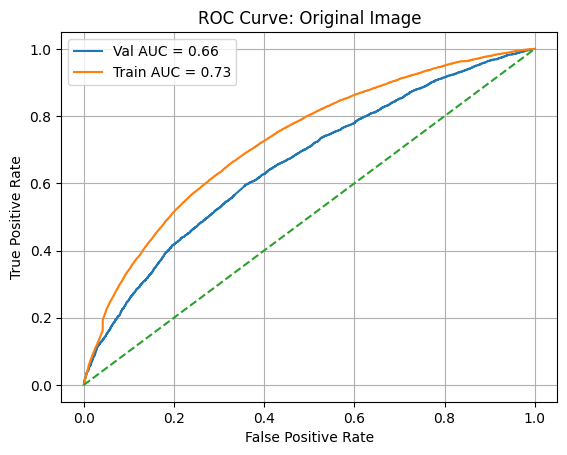


 Training report: 
              precision    recall  f1-score   support

           0       0.87      0.66      0.75     51977
           1       0.37      0.67      0.48     15761

    accuracy                           0.66     67738
   macro avg       0.62      0.67      0.62     67738
weighted avg       0.75      0.66      0.69     67738


 Validation report: 
              precision    recall  f1-score   support

           0       0.84      0.66      0.74     15011
           1       0.33      0.57      0.42      4336

    accuracy                           0.64     19347
   macro avg       0.59      0.62      0.58     19347
weighted avg       0.73      0.64      0.67     19347



In [47]:
# train svm on original image
orixTrain_bal, oriyTrain_bal = downsample(orixTrain, oriyTrain)

clfOri = SVC(kernel='rbf', probability=True, random_state=42)
clfOri.fit(orixTrain_bal, oriyTrain_bal)

y_predOri, yTrain_predOri = calcMetrics(clfOri, orixTrain, oriyTrain, orixVal, oriyVal, 'Original Image')

# convert to 1 and 0
oriyTrain = ([1 if label == "tumor" else 0 for label in oriyTrain])
oriyVal = ([1 if label == "tumor" else 0 for label in oriyVal])

print("\n Training report: ")
print(classification_report(oriyTrain, yTrain_predOri))
print("\n Validation report: ")
print(classification_report(oriyVal, y_predOri))

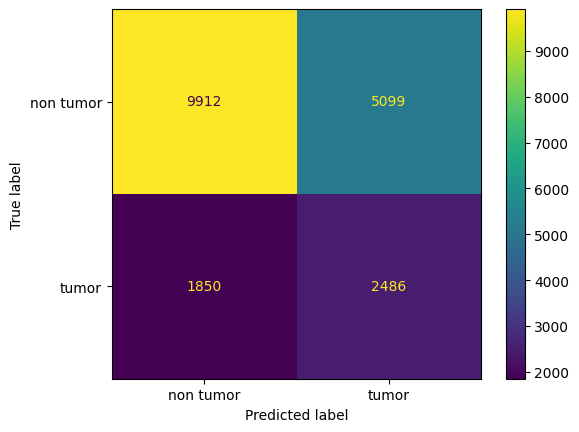

In [61]:
confusionMatrix = confusion_matrix(oriyVal, y_predOri)
disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=np.array(['non tumor', 'tumor']))
disp.plot()
plt.show()

In [48]:
# get RMSE
rmse2, trueCount2, predCount2 = calcRMSE(clfOri)

# print(f'avg num tumors: {sum(trueCount2)/len(trueCount2)}')
# print(sum(trueCount2))
# print(sum(predCount2))
# print(trueCount2)
# print(predCount2)

100%|██████████| 387/387 [01:02<00:00,  6.17it/s]

Tumor Count RMSE on Validation Set: 13.146756607708442


Which pathological structures are easier to segregate from tumours?

{'apoptotic_body': 0.4603174603174603, 'ductal_epithelium': 0.5446428571428571, 'fibroblast': 0.3869363395225464, 'lymphocyte': 0.3931490852471779, 'macrophage': 0.4848260547742413, 'mitotic_figure': 0.6614583333333334, 'myoepithelium': 0.5, 'plasma_cell': 0.39814814814814814, 'tumor': 0.41882691804137206, 'unlabeled': 0.3372262773722628, 'vascular_endothelium': 0.5238095238095238}


Text(0.5, 1.0, 'Misclassification by Class')

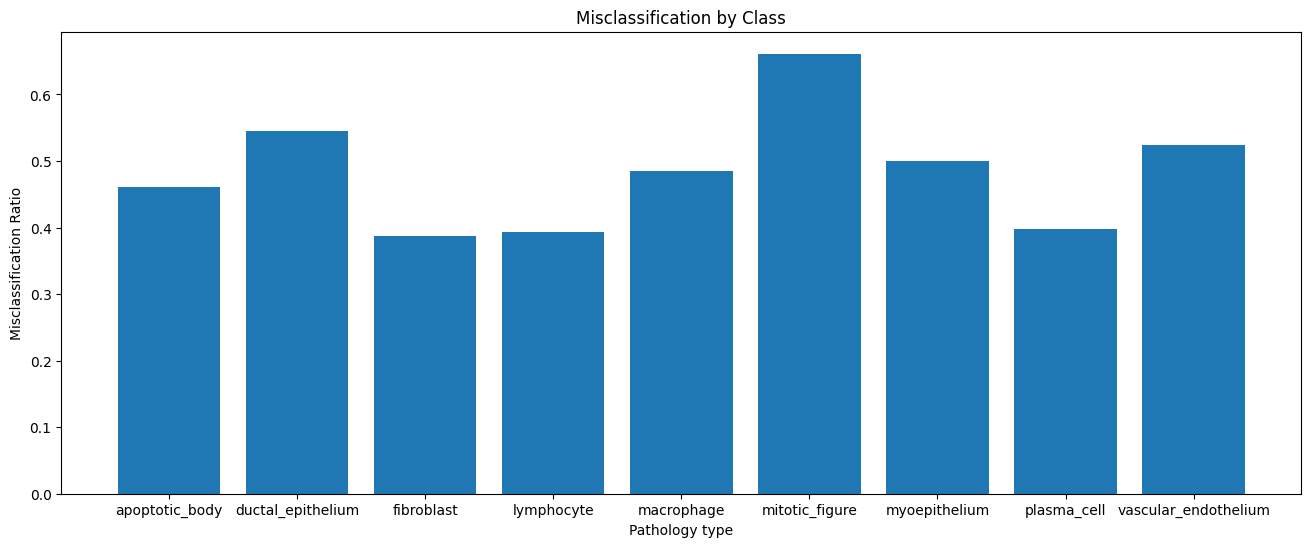

In [63]:
## find frequency of misclassification per class ##
# check what class misclassified labels belong to
misclassified = {}
# initialize dict
for label in np.unique(valLabels):
    misclassified[label] = 0

# count each instance misclassified
for i, label in enumerate(yPredSave):
    if label != yVal[i]:
        misclassified[valLabels[i]] += 1

# get frequency of each class label
frequency = {}
for label in np.unique(valLabels):
    frequency[label] = 0

for i, label in enumerate(valLabels):
    frequency[label] += 1

# divide num misclassified by their frequency
for label in misclassified.keys():
    misclassified[label] = misclassified[label] / frequency[label]

print(misclassified)
misclassified.pop('unlabeled')
misclassified.pop('tumor') # most misclassified classes
plt.figure(figsize=(16,6))
plt.bar(misclassified.keys(), misclassified.values())
plt.ylabel('Misclassification Ratio')
plt.xlabel('Pathology type')
plt.title('Misclassification by Class')
